In [1]:
import cv2

import numpy as np
import supervision as sv

from tqdm import tqdm
from ultralytics import YOLO
from supervision.assets import VideoAssets, download_assets
from collections import defaultdict, deque

In [11]:
SOURCE_VIDEO_PATH = "vehicles.mp4"
# TARGET_VIDEO_PATH = "vehicles-result.mp4"
CONFIDENCE_THRESHOLD = 0.3
IOU_THRESHOLD = 0.5
MODEL_NAME = "visdrone_8x.pt"
MODEL_RESOLUTION = 1280

In [3]:
SOURCE = np.array([
    [1252, 787],
    [2298, 803],
    [5039, 2159],
    [-550, 2159]
])

TARGET_WIDTH = 25
TARGET_HEIGHT = 250

TARGET = np.array([
    [0, 0],
    [TARGET_WIDTH - 1, 0],
    [TARGET_WIDTH - 1, TARGET_HEIGHT - 1],
    [0, TARGET_HEIGHT - 1],
])

In [4]:
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)
frame_iterator = iter(frame_generator)
frame = next(frame_iterator)

SupervisionWarnings: red is deprecated: `Color.red()` is deprecated and will be removed in `supervision-0.22.0`. Use `Color.RED` instead.


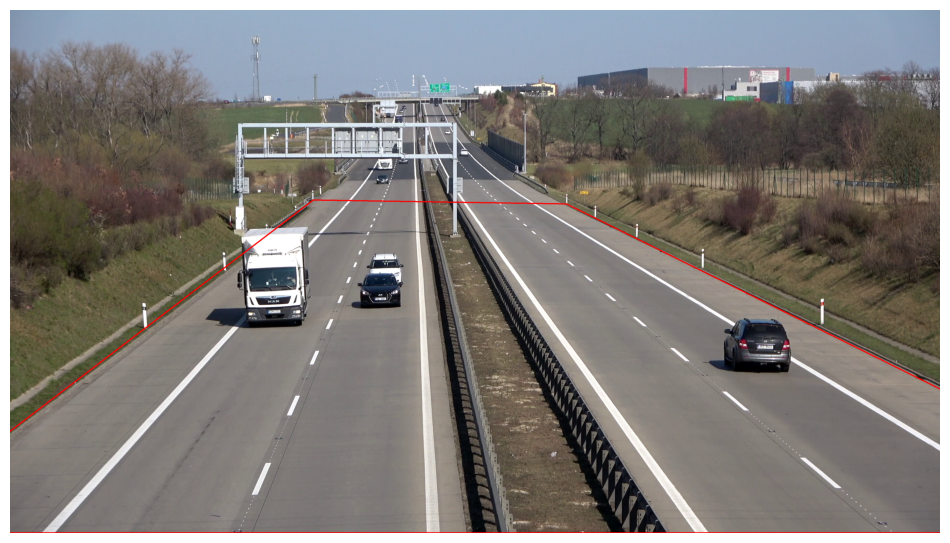

In [5]:
annotated_frame = frame.copy()
annotated_frame = sv.draw_polygon(scene=annotated_frame, polygon=SOURCE, color=sv.Color.red(), thickness=4)
sv.plot_image(annotated_frame)

In [6]:
class ViewTransformer:

    def __init__(self, source: np.ndarray, target: np.ndarray) -> None:
        source = source.astype(np.float32)
        target = target.astype(np.float32)
        self.m = cv2.getPerspectiveTransform(source, target)

    def transform_points(self, points: np.ndarray) -> np.ndarray:
        if points.size == 0:
            return points

        reshaped_points = points.reshape(-1, 1, 2).astype(np.float32)
        transformed_points = cv2.perspectiveTransform(reshaped_points, self.m)
        return transformed_points.reshape(-1, 2)

In [7]:
view_transformer = ViewTransformer(source=SOURCE, target=TARGET)

In [12]:
# to display class names on top
# Initialize the YOLO model

TARGET_VIDEO_PATH_ = "vehicles-result_visdrone.mp4"
model = YOLO(MODEL_NAME)

# Get class names from the YOLO model
class_names = model.names  # Assuming the model has a 'names' attribute for class names

# Extract video information and generate frames
video_info = sv.VideoInfo.from_video_path(video_path=SOURCE_VIDEO_PATH)
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)

# Initialize ByteTrack tracker with the new parameter name
byte_track = sv.ByteTrack(
    frame_rate=video_info.fps, track_activation_threshold=CONFIDENCE_THRESHOLD
)

# Configure annotators with direct values
thickness = 2
text_scale = 1

bounding_box_annotator = sv.BoundingBoxAnnotator(
    thickness=thickness
)
label_annotator = sv.LabelAnnotator(
    text_scale=text_scale,
    text_thickness=thickness,
    text_position=sv.Position.TOP_CENTER  # Changed position to top center for class names
)
trace_annotator = sv.TraceAnnotator(
    thickness=thickness,
    trace_length=video_info.fps * 2,
    position=sv.Position.BOTTOM_CENTER
)

# Define the polygon zone for filtering
polygon_zone = sv.PolygonZone(
    polygon=SOURCE,
    frame_resolution_wh=video_info.resolution_wh
)

# Initialize coordinates storage
coordinates = defaultdict(lambda: deque(maxlen=video_info.fps))

# Open target video
with sv.VideoSink(TARGET_VIDEO_PATH_, video_info) as sink:

    # Loop over source video frames
    for frame in tqdm(frame_generator, total=video_info.total_frames):

        # Run YOLO model for detections
        result = model(frame, imgsz=MODEL_RESOLUTION, verbose=False)[0]
        detections = sv.Detections.from_ultralytics(result)

        # Filter detections by confidence and class
        detections = detections[detections.confidence > CONFIDENCE_THRESHOLD]
        detections = detections[detections.class_id != 0]

        # Filter detections within the polygon zone
        detections = detections[polygon_zone.trigger(detections)]

        # Apply Non-Max Suppression (NMS)
        detections = detections.with_nms(IOU_THRESHOLD)

        # Update tracker with detections
        detections = byte_track.update_with_detections(detections=detections)

        # Extract bottom center points of detections
        points = detections.get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER)

        # Transform points to target RoI
        points = view_transformer.transform_points(points=points).astype(int)

        # Store detections' positions
        for tracker_id, [_, y] in zip(detections.tracker_id, points):
            coordinates[tracker_id].append(y)

        # Format labels
        labels = []
        for i, tracker_id in enumerate(detections.tracker_id):
            class_id = detections.class_id[i]
            class_name = class_names[class_id]
            if len(coordinates[tracker_id]) < video_info.fps / 2:
                labels.append(f"{class_name} #{tracker_id}")
            else:
                # Calculate speed
                coordinate_start = coordinates[tracker_id][-1]
                coordinate_end = coordinates[tracker_id][0]
                distance = abs(coordinate_start - coordinate_end)
                time = len(coordinates[tracker_id]) / video_info.fps
                speed = distance / time * 3.6*2/3
                labels.append(f"{class_name} #{tracker_id} {int(speed)} km/h")

        # Annotate frame
        annotated_frame = frame.copy()
        annotated_frame = trace_annotator.annotate(
            scene=annotated_frame, detections=detections
        )
        annotated_frame = bounding_box_annotator.annotate(
            scene=annotated_frame, detections=detections
        )
        annotated_frame = label_annotator.annotate(
            scene=annotated_frame, detections=detections, labels=labels
        )

        # Add frame to target video
        sink.write_frame(annotated_frame)


SupervisionWarnings: The `frame_resolution_wh` parameter is no longer required and will be dropped in version supervision-0.24.0. The mask resolution is now calculated automatically based on the polygon coordinates.
100%|██████████| 538/538 [1:17:06<00:00,  8.60s/it]


In [13]:
# to display class names on top
# Initialize the YOLO model
SOURCE_VIDEO_PATH = "test.mp4"
TARGET_VIDEO_PATH_ = "test_visdrone.mp4"
model = YOLO(MODEL_NAME)

# Get class names from the YOLO model
class_names = model.names  # Assuming the model has a 'names' attribute for class names

# Extract video information and generate frames
video_info = sv.VideoInfo.from_video_path(video_path=SOURCE_VIDEO_PATH)
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)

# Initialize ByteTrack tracker with the new parameter name
byte_track = sv.ByteTrack(
    frame_rate=video_info.fps, track_activation_threshold=CONFIDENCE_THRESHOLD
)

# Configure annotators with direct values
thickness = 2
text_scale = 1

bounding_box_annotator = sv.BoundingBoxAnnotator(
    thickness=thickness
)
label_annotator = sv.LabelAnnotator(
    text_scale=text_scale,
    text_thickness=thickness,
    text_position=sv.Position.TOP_CENTER  # Changed position to top center for class names
)
trace_annotator = sv.TraceAnnotator(
    thickness=thickness,
    trace_length=video_info.fps * 2,
    position=sv.Position.BOTTOM_CENTER
)

# Define the polygon zone for filtering
polygon_zone = sv.PolygonZone(
    polygon=SOURCE,
    frame_resolution_wh=video_info.resolution_wh
)

# Initialize coordinates storage
coordinates = defaultdict(lambda: deque(maxlen=video_info.fps))

# Open target video
with sv.VideoSink(TARGET_VIDEO_PATH_, video_info) as sink:

    # Loop over source video frames
    for frame in tqdm(frame_generator, total=video_info.total_frames):

        # Run YOLO model for detections
        result = model(frame, imgsz=MODEL_RESOLUTION, verbose=False)[0]
        detections = sv.Detections.from_ultralytics(result)

        # Filter detections by confidence and class
        detections = detections[detections.confidence > CONFIDENCE_THRESHOLD]
        detections = detections[detections.class_id != 0]

        # Filter detections within the polygon zone
        detections = detections[polygon_zone.trigger(detections)]

        # Apply Non-Max Suppression (NMS)
        detections = detections.with_nms(IOU_THRESHOLD)

        # Update tracker with detections
        detections = byte_track.update_with_detections(detections=detections)

        # Extract bottom center points of detections
        points = detections.get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER)

        # Transform points to target RoI
        points = view_transformer.transform_points(points=points).astype(int)

        # Store detections' positions
        for tracker_id, [_, y] in zip(detections.tracker_id, points):
            coordinates[tracker_id].append(y)

        # Format labels
        labels = []
        for i, tracker_id in enumerate(detections.tracker_id):
            class_id = detections.class_id[i]
            class_name = class_names[class_id]
            if len(coordinates[tracker_id]) < video_info.fps / 2:
                labels.append(f"{class_name} #{tracker_id}")
            else:
                # Calculate speed
                coordinate_start = coordinates[tracker_id][-1]
                coordinate_end = coordinates[tracker_id][0]
                distance = abs(coordinate_start - coordinate_end)
                time = len(coordinates[tracker_id]) / video_info.fps
                speed = distance / time * 3.6*2/3
                labels.append(f"{class_name} #{tracker_id} {int(speed)} km/h")

        # Annotate frame
        annotated_frame = frame.copy()
        annotated_frame = trace_annotator.annotate(
            scene=annotated_frame, detections=detections
        )
        annotated_frame = bounding_box_annotator.annotate(
            scene=annotated_frame, detections=detections
        )
        annotated_frame = label_annotator.annotate(
            scene=annotated_frame, detections=detections, labels=labels
        )

        # Add frame to target video
        sink.write_frame(annotated_frame)


SupervisionWarnings: The `frame_resolution_wh` parameter is no longer required and will be dropped in version supervision-0.24.0. The mask resolution is now calculated automatically based on the polygon coordinates.
100%|██████████| 440/440 [56:24<00:00,  7.69s/it]


In [14]:
# to display class names on top
# Initialize the YOLO model
SOURCE_VIDEO_PATH = "test2.mp4"
TARGET_VIDEO_PATH_ = "test2_visdrone.mp4"
model = YOLO("visdrone_8x.pt")

# Get class names from the YOLO model
class_names = model.names  # Assuming the model has a 'names' attribute for class names

# Extract video information and generate frames
video_info = sv.VideoInfo.from_video_path(video_path=SOURCE_VIDEO_PATH)
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)

# Initialize ByteTrack tracker with the new parameter name
byte_track = sv.ByteTrack(
    frame_rate=video_info.fps, track_activation_threshold=CONFIDENCE_THRESHOLD
)

# Configure annotators with direct values
thickness = 2
text_scale = 1

bounding_box_annotator = sv.BoundingBoxAnnotator(
    thickness=thickness
)
label_annotator = sv.LabelAnnotator(
    text_scale=text_scale,
    text_thickness=thickness,
    text_position=sv.Position.TOP_CENTER  # Changed position to top center for class names
)
trace_annotator = sv.TraceAnnotator(
    thickness=thickness,
    trace_length=video_info.fps * 2,
    position=sv.Position.BOTTOM_CENTER
)

# Define the polygon zone for filtering
polygon_zone = sv.PolygonZone(
    polygon=SOURCE,
    frame_resolution_wh=video_info.resolution_wh
)

# Initialize coordinates storage
coordinates = defaultdict(lambda: deque(maxlen=video_info.fps))

# Open target video
with sv.VideoSink(TARGET_VIDEO_PATH_, video_info) as sink:

    # Loop over source video frames
    for frame in tqdm(frame_generator, total=video_info.total_frames):

        # Run YOLO model for detections
        result = model(frame, imgsz=MODEL_RESOLUTION, verbose=False)[0]
        detections = sv.Detections.from_ultralytics(result)

        # Filter detections by confidence and class
        detections = detections[detections.confidence > CONFIDENCE_THRESHOLD]
        detections = detections[detections.class_id != 0]

        # Filter detections within the polygon zone
        detections = detections[polygon_zone.trigger(detections)]

        # Apply Non-Max Suppression (NMS)
        detections = detections.with_nms(IOU_THRESHOLD)

        # Update tracker with detections
        detections = byte_track.update_with_detections(detections=detections)

        # Extract bottom center points of detections
        points = detections.get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER)

        # Transform points to target RoI
        points = view_transformer.transform_points(points=points).astype(int)

        # Store detections' positions
        for tracker_id, [_, y] in zip(detections.tracker_id, points):
            coordinates[tracker_id].append(y)

        # Format labels
        labels = []
        for i, tracker_id in enumerate(detections.tracker_id):
            class_id = detections.class_id[i]
            class_name = class_names[class_id]
            if len(coordinates[tracker_id]) < video_info.fps / 2:
                labels.append(f"{class_name} #{tracker_id}")
            else:
                # Calculate speed
                coordinate_start = coordinates[tracker_id][-1]
                coordinate_end = coordinates[tracker_id][0]
                distance = abs(coordinate_start - coordinate_end)
                time = len(coordinates[tracker_id]) / video_info.fps
                speed = distance / time * 3.6*2/3
                labels.append(f"{class_name} #{tracker_id} {int(speed)} km/h")

        # Annotate frame
        annotated_frame = frame.copy()
        annotated_frame = trace_annotator.annotate(
            scene=annotated_frame, detections=detections
        )
        annotated_frame = bounding_box_annotator.annotate(
            scene=annotated_frame, detections=detections
        )
        annotated_frame = label_annotator.annotate(
            scene=annotated_frame, detections=detections, labels=labels
        )

        # Add frame to target video
        sink.write_frame(annotated_frame)


SupervisionWarnings: The `frame_resolution_wh` parameter is no longer required and will be dropped in version supervision-0.24.0. The mask resolution is now calculated automatically based on the polygon coordinates.
100%|██████████| 612/612 [1:21:37<00:00,  8.00s/it]


In [15]:
SOURCE = np.array([
    [305, 260],
    [405, 245],
    [802,475],
    [24, 475]
])

TARGET_WIDTH = 15
TARGET_HEIGHT = 150

TARGET = np.array([
    [0, 0],
    [TARGET_WIDTH - 1, 0],
    [TARGET_WIDTH - 1, TARGET_HEIGHT - 1],
    [0, TARGET_HEIGHT - 1],
])

In [16]:
class ViewTransformer:

    def __init__(self, source: np.ndarray, target: np.ndarray) -> None:
        source = source.astype(np.float32)
        target = target.astype(np.float32)
        self.m = cv2.getPerspectiveTransform(source, target)

    def transform_points(self, points: np.ndarray) -> np.ndarray:
        if points.size == 0:
            return points

        reshaped_points = points.reshape(-1, 1, 2).astype(np.float32)
        transformed_points = cv2.perspectiveTransform(reshaped_points, self.m)
        return transformed_points.reshape(-1, 2)

In [17]:
view_transformer = ViewTransformer(source=SOURCE, target=TARGET)

In [18]:
# to display class names on top
# Initialize the YOLO model
SOURCE_VIDEO_PATH = "test.mp4"
TARGET_VIDEO_PATH_ = "test_visdrone2.mp4"
model = YOLO("visdrone_8x.pt")

# Get class names from the YOLO model
class_names = model.names  # Assuming the model has a 'names' attribute for class names

# Extract video information and generate frames
video_info = sv.VideoInfo.from_video_path(video_path=SOURCE_VIDEO_PATH)
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)

# Initialize ByteTrack tracker with the new parameter name
byte_track = sv.ByteTrack(
    frame_rate=video_info.fps, track_activation_threshold=CONFIDENCE_THRESHOLD
)

# Configure annotators with direct values
thickness = 2
text_scale = 1

bounding_box_annotator = sv.BoundingBoxAnnotator(
    thickness=thickness
)
label_annotator = sv.LabelAnnotator(
    text_scale=text_scale,
    text_thickness=thickness,
    text_position=sv.Position.TOP_CENTER  # Changed position to top center for class names
)
trace_annotator = sv.TraceAnnotator(
    thickness=thickness,
    trace_length=video_info.fps * 2,
    position=sv.Position.BOTTOM_CENTER
)

# Define the polygon zone for filtering
polygon_zone = sv.PolygonZone(
    polygon=SOURCE,
    frame_resolution_wh=video_info.resolution_wh
)

# Initialize coordinates storage
coordinates = defaultdict(lambda: deque(maxlen=video_info.fps))

# Open target video
with sv.VideoSink(TARGET_VIDEO_PATH_, video_info) as sink:

    # Loop over source video frames
    for frame in tqdm(frame_generator, total=video_info.total_frames):

        # Run YOLO model for detections
        result = model(frame, imgsz=MODEL_RESOLUTION, verbose=False)[0]
        detections = sv.Detections.from_ultralytics(result)

        # Filter detections by confidence and class
        detections = detections[detections.confidence > CONFIDENCE_THRESHOLD]
        detections = detections[detections.class_id != 0]

        # Filter detections within the polygon zone
        detections = detections[polygon_zone.trigger(detections)]

        # Apply Non-Max Suppression (NMS)
        detections = detections.with_nms(IOU_THRESHOLD)

        # Update tracker with detections
        detections = byte_track.update_with_detections(detections=detections)

        # Extract bottom center points of detections
        points = detections.get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER)

        # Transform points to target RoI
        points = view_transformer.transform_points(points=points).astype(int)

        # Store detections' positions
        for tracker_id, [_, y] in zip(detections.tracker_id, points):
            coordinates[tracker_id].append(y)

        # Format labels
        labels = []
        for i, tracker_id in enumerate(detections.tracker_id):
            class_id = detections.class_id[i]
            class_name = class_names[class_id]
            if len(coordinates[tracker_id]) < video_info.fps / 2:
                labels.append(f"{class_name} #{tracker_id}")
            else:
                # Calculate speed
                coordinate_start = coordinates[tracker_id][-1]
                coordinate_end = coordinates[tracker_id][0]
                distance = abs(coordinate_start - coordinate_end)
                time = len(coordinates[tracker_id]) / video_info.fps
                speed = distance / time * 3.6*2/3
                labels.append(f"{class_name} #{tracker_id} {int(speed)} km/h")

        # Annotate frame
        annotated_frame = frame.copy()
        annotated_frame = trace_annotator.annotate(
            scene=annotated_frame, detections=detections
        )
        annotated_frame = bounding_box_annotator.annotate(
            scene=annotated_frame, detections=detections
        )
        annotated_frame = label_annotator.annotate(
            scene=annotated_frame, detections=detections, labels=labels
        )

        # Add frame to target video
        sink.write_frame(annotated_frame)


SupervisionWarnings: The `frame_resolution_wh` parameter is no longer required and will be dropped in version supervision-0.24.0. The mask resolution is now calculated automatically based on the polygon coordinates.
100%|██████████| 440/440 [55:31<00:00,  7.57s/it]


In [20]:
SOURCE = np.array([
    [210, 192],
    [624, 197],
    [-390,475],
    [1230, 475]
])

TARGET_WIDTH = 30
TARGET_HEIGHT = 200

TARGET = np.array([
    [0, 0],
    [TARGET_WIDTH - 1, 0],
    [TARGET_WIDTH - 1, TARGET_HEIGHT - 1],
    [0, TARGET_HEIGHT - 1],
])



class ViewTransformer:

    def __init__(self, source: np.ndarray, target: np.ndarray) -> None:
        source = source.astype(np.float32)
        target = target.astype(np.float32)
        self.m = cv2.getPerspectiveTransform(source, target)

    def transform_points(self, points: np.ndarray) -> np.ndarray:
        if points.size == 0:
            return points

        reshaped_points = points.reshape(-1, 1, 2).astype(np.float32)
        transformed_points = cv2.perspectiveTransform(reshaped_points, self.m)
        return transformed_points.reshape(-1, 2)


view_transformer = ViewTransformer(source=SOURCE, target=TARGET)



# to display class names on top
# Initialize the YOLO model
SOURCE_VIDEO_PATH = "test2.mp4"
TARGET_VIDEO_PATH_ = "test2_visdrone2.mp4"
model = YOLO("visdrone_8x.pt")

# Get class names from the YOLO model
class_names = model.names  # Assuming the model has a 'names' attribute for class names

# Extract video information and generate frames
video_info = sv.VideoInfo.from_video_path(video_path=SOURCE_VIDEO_PATH)
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)

# Initialize ByteTrack tracker with the new parameter name
byte_track = sv.ByteTrack(
    frame_rate=video_info.fps, track_activation_threshold=CONFIDENCE_THRESHOLD
)

# Configure annotators with direct values
thickness = 2
text_scale = 1

bounding_box_annotator = sv.BoundingBoxAnnotator(
    thickness=thickness
)
label_annotator = sv.LabelAnnotator(
    text_scale=text_scale,
    text_thickness=thickness,
    text_position=sv.Position.TOP_CENTER  # Changed position to top center for class names
)
trace_annotator = sv.TraceAnnotator(
    thickness=thickness,
    trace_length=video_info.fps * 2,
    position=sv.Position.BOTTOM_CENTER
)

# Define the polygon zone for filtering
polygon_zone = sv.PolygonZone(
    polygon=SOURCE,
    frame_resolution_wh=video_info.resolution_wh
)

# Initialize coordinates storage
coordinates = defaultdict(lambda: deque(maxlen=video_info.fps))

# Open target video
with sv.VideoSink(TARGET_VIDEO_PATH_, video_info) as sink:

    # Loop over source video frames
    for frame in tqdm(frame_generator, total=video_info.total_frames):

        # Run YOLO model for detections
        result = model(frame, imgsz=MODEL_RESOLUTION, verbose=False)[0]
        detections = sv.Detections.from_ultralytics(result)

        # Filter detections by confidence and class
        detections = detections[detections.confidence > CONFIDENCE_THRESHOLD]
        detections = detections[detections.class_id != 0]

        # Filter detections within the polygon zone
        detections = detections[polygon_zone.trigger(detections)]

        # Apply Non-Max Suppression (NMS)
        detections = detections.with_nms(IOU_THRESHOLD)

        # Update tracker with detections
        detections = byte_track.update_with_detections(detections=detections)

        # Extract bottom center points of detections
        points = detections.get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER)

        # Transform points to target RoI
        points = view_transformer.transform_points(points=points).astype(int)

        # Store detections' positions
        for tracker_id, [_, y] in zip(detections.tracker_id, points):
            coordinates[tracker_id].append(y)

        # Format labels
        labels = []
        for i, tracker_id in enumerate(detections.tracker_id):
            class_id = detections.class_id[i]
            class_name = class_names[class_id]
            if len(coordinates[tracker_id]) < video_info.fps / 2:
                labels.append(f"{class_name} #{tracker_id}")
            else:
                # Calculate speed
                coordinate_start = coordinates[tracker_id][-1]
                coordinate_end = coordinates[tracker_id][0]
                distance = abs(coordinate_start - coordinate_end)
                time = len(coordinates[tracker_id]) / video_info.fps
                speed = distance / time * 3.6*2/3
                labels.append(f"{class_name} #{tracker_id} {int(speed)} km/h")

        # Annotate frame
        annotated_frame = frame.copy()
        annotated_frame = trace_annotator.annotate(
            scene=annotated_frame, detections=detections
        )
        annotated_frame = bounding_box_annotator.annotate(
            scene=annotated_frame, detections=detections
        )
        annotated_frame = label_annotator.annotate(
            scene=annotated_frame, detections=detections, labels=labels
        )

        # Add frame to target video
        sink.write_frame(annotated_frame)


SupervisionWarnings: The `frame_resolution_wh` parameter is no longer required and will be dropped in version supervision-0.24.0. The mask resolution is now calculated automatically based on the polygon coordinates.
100%|██████████| 612/612 [1:44:31<00:00, 10.25s/it]
